In [225]:
import argparse

from utils.logger import get_logger
from utils.arg_parser import Argments
from loader.data_loader import GeneralDataLoaderCls, NbsDataLoaderCls,\
                               GeneralDataLoaderSeg, NbsDataLoaderSeg,NbsDataLoaderRgs
from runners.cnn_runner import CnnRunner
from runners.nbs_runner import NbsRunner
from runners.mcd_runner import McdRunner
from models.regression import Reg_model
import torch
import numpy as np
from tqdm import tqdm
from runners.base_runner import gather_tensor

print(torch.cuda.is_available())

True


In [227]:
Reg_model

models.regression.Reg_model

In [228]:
from models.__init__ import _get_model

In [229]:
model = _get_model('Reg_model','nbs',1)

In [230]:
argparser = argparse.ArgumentParser()
# adding the values
argparser.add_argument("yaml")
argparser.add_argument("--phase", default="train", type=str) 
argparser.add_argument("--index", default=-1, type=int) 
argparser.add_argument("--gpus", default="0", type=str)
argparser.add_argument("--local_rank", default=-1, type=int) 
# save 
cmd_args = argparser.parse_args(["example"])

arg = Argments(f"scripts/{cmd_args.yaml}.yaml", cmd_args) # stll many funcs to read
setup = arg['setup']
model_path = arg['path/model_path']
logger = get_logger(f"{model_path}/log.txt")

if setup['rank'] == 0:
    logger.info(arg)

model_type = setup['model_type']
dataset = arg['path/dataset']
is_seg = False

if 'nbs' in model_type: # added in n_a (comparing the else loop)
        
    _data_loader = NbsDataLoaderRgs # n_a exists
    data_loader = _data_loader(dataset, setup['batch_size'],
                                setup['n_a'], setup['cpus'], setup['seed'])
    runner = NbsRunner(data_loader, **arg.module, num_epoch=setup['num_epoch'], # core part 
                        logger=logger, model_path=model_path, rank=setup['rank'],
                        epoch_th=setup['epoch_th'], num_mc=setup['num_mc'],
                        adv_training=setup['adv_training'])

setting the python env
cmd_args.local_rank:  -1
torch.Size([100000, 100])
torch.Size([100000, 1])
here1
here3
here4
here2


In [231]:
runner.load('best.pth')
loader = runner.loader.load('test')
if runner.rank == 0:
    t_iter = tqdm(loader, total=runner.loader.len)
else:
    t_iter = loader

outputs = []
labels = []
metrics = []
runner.model.eval()
for img, label in t_iter:
    _metric, output = runner._valid_a_batch(img, label, with_output=True)
    labels += label.cpu().squeeze().tolist()
    outputs += output.cpu().mean(0).squeeze().tolist() # gather_tensor(output).cpu().numpy()
    metrics += [_metric.cpu().item()] # gather_tensor(_metric).cpu().numpy()
# labels = np.concatenate(labels)
# outputs = np.concatenate(outputs, axis=1)
err = np.mean(metrics[:])
# nll, brier = calc_nll_brier_mc(outputs, labels)
# print("Becarful, the num_class set as 1")
print(f"[Test] loss: {err:.5f} ")
# log += f"NLL : {nll:.2f}, Brier : {brier:.2f}"


[Test] loss: 0.84621 


In [232]:
print(len(labels))
print(len(outputs))

2000
2000


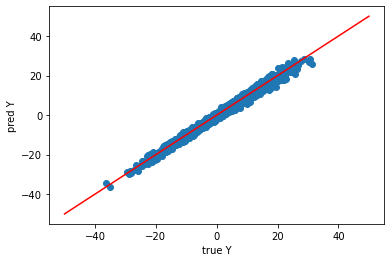

In [233]:
import matplotlib.pyplot as plt
plt.plot([-50,50],[-50,50],color="red")
plt.scatter(labels,outputs)
plt.xlabel("true Y")
plt.ylabel("pred Y")
plt.show()

In [199]:
beta = torch.ones([100,1])

train_X = torch.normal(0,1,size=(100000,100))
train_y = torch.mm(train_X,beta)
test_X = torch.normal(0,1,size=(100000,100))
test_y = torch.mm(test_X,beta)

In [206]:
torch.tensor(labels).min()

tensor(-40.9156)

In [207]:
print(torch.tensor(labels).max())
print(torch.tensor(labels).min())


tensor(32.9427)
tensor(-40.9156)


In [217]:
model_info = torch.load("outs/nbs/Reg_model/custom_train/model.pth")

In [224]:
model_info["score"]

98.0163627243042